# Example Script: Finger Abduction Paradigm
(If you have any problems please [raise an issue on Github](https://github.com/neurofractal/analyse_OPMEG/issues), rather than emailing)

### Add the relevent packages to your MATLAB path
- Download the data from here: **[LINK](https://liveuclac-my.sharepoint.com/:f:/g/personal/skgtsey_ucl_ac_uk/ErP0UX3sbRVCmnKrttLDtNIBOKOcXwNZiOAwsqArAuvI6g?e=jFNVEH)**

In [8]:
%% Paths (RS)
fieldtripDir    = '/Users/rseymoue/Documents/GitHub/fieldtrip';
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG';
data_dir        = '/Volumes/Robert T5/OPM_data/benchmarking_26_02/';
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/';

% Add Fieldtrip to path
disp('Adding Fieldtrip and analyse_OPMEG to your MATLAB path');
addpath(fieldtripDir)
ft_defaults;

% Add analyse_OPMEG Scripts to path
addpath(genpath(script_dir));

% cd to save dir
cd(save_dir)

Adding Fieldtrip and analyse_OPMEG to your MATLAB path


### Load in the data and plot PSD


the call to "ft_selectdata" took 4 seconds and required the additional allocation of an estimated 266 MB


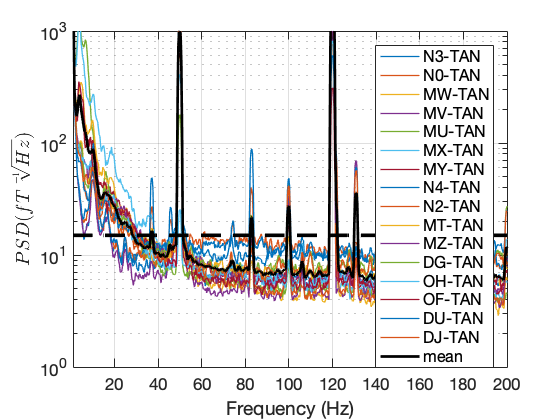

In [10]:
%% (2) Start preprocessing.
% Read in the raw data.

% Read in the raw data using BIDS
cfg             = [];
cfg.folder      = data_dir;
cfg.precision   = 'single';
cfg.bids.task   = 'finger_abduction';
cfg.bids.sub    = '004';
cfg.bids.ses    = '001';
cfg.bids.run    = '001';
rawData        = ft_opm_create(cfg);

%% Plot PSD
cfg                 = [];
cfg.channel         = vertcat(ft_channelselection_opm('TAN',rawData));
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [1 200];
cfg.plot            = 'yes';
pow                 = ft_opm_psd(cfg,rawData);
ylim([1, 1000])

### Do some signal processing and "Synthetic Gradiometry" (aka referencing)
(Only using TAN sensors from this point onwards)
- Due to low-frequency drift, alongside spectral peaks at 30-35Hz, 50Hz and 80-85Hz, we include the option cfg.filter_ref = [1 3; 3 30; 35 40; 40 60; 80 85]; when performing synthetic gradiometry. This will filter the reference data between 1-3Hz, 3-30Hz, 35-40Hz, 40-60Hz and 80-85Hz, and include these as regressors.


the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 8 seconds and required the additional allocation of an estimated 820 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 641 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 4 seconds and required the additional allocation of an estimated 641 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 197 MB
Selected 12 data channels
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 131 MB
Selected  8 reference channels
Filtering reference data:   1Hz -   3Hz ... 
Filtering reference data:   3Hz -  30Hz ... 
Filtering reference data:  35Hz -  40Hz ... 
Filtering reference data:  40Hz -  60Hz ... 
Filtering reference data:  80Hz -  85Hz ...

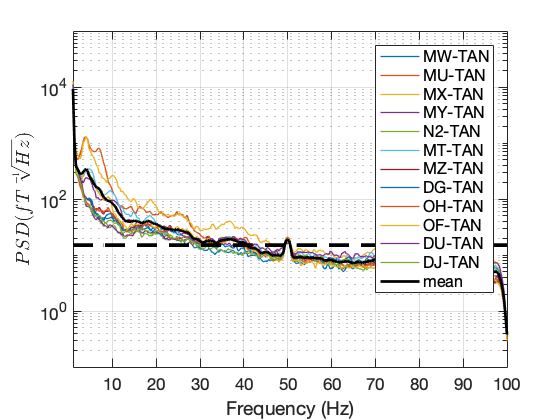

In [11]:
%% Low-pass filter at 100Hz to remove large high-frequency peaks
cfg = [];
cfg.lpfilter    = 'yes';
cfg.lpfreq      = 100;
rawData         = ft_preprocessing(cfg,rawData);

%% Band-stop filter around 100Hz
cfg = [];
cfg.bsfilter    = 'yes';
cfg.bsfreq      = [99 101];
cfg.bsfiltord   = 3;
rawData         = ft_preprocessing(cfg,rawData);

%% Perform synthetic gradiometry on TAN sensors
cfg = [];
cfg.channel = vertcat(ft_channelselection_opm('TAN',rawData),...
     '-N0-TAN','-N4-TAN','-N3-TAN','-MV-TAN');
cfg.refchannel = 'MEGREF';
cfg.filter_ref = [1 3; 3 30; 35 40; 40 60; 80 85];
cfg.derivative = 'yes';
[rawData_meg]  = ft_opm_synth_gradiometer(cfg,rawData);

% 
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [1 100];
cfg.plot            = 'yes';
pow                 = ft_opm_psd(cfg,rawData_meg);

### Do some further signal processing on the data
- Band-stop filter at 50Hz
- High-pass filter at 2Hz
- Resample to 1000Hz

In [13]:
%% Do some signal processing on the data

% BS filter
cfg             = [];
cfg.bsfilter    = 'yes';
cfg.bsfreq      = [49 51];
cfg.bsfiltord   = 3;
rawData_meg     = ft_preprocessing(cfg,rawData_meg);

cfg = [];
cfg.hpfilter    = 'yes';
cfg.hpfreq      = 2;
cfg.hpfiltord   = 3;
rawData_meg         = ft_preprocessing(cfg,rawData_meg);

% Resample to 1000Hz
cfg = [];
cfg.resamplefs = 1000;
[rawData_meg] = ft_resampledata(cfg, rawData_meg);

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 1 seconds and required the additional allocation of an estimated 304 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 197 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 1 seconds and required the additional allocation of an estimated 197 MB
the input is raw data with 12 channels and 1 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 195 MB
resampling data
resampling data in trial 1 from 1
original sampling rate = 6000 Hz
new sampling rate = 1000 Hz
the call to "ft_resampledata" took 2 seconds and required the additional allocation of an estimated 301 MB


### Epoch the data
This could be done slightly better (in terms of coding efficiency), and will probably need to be adapted specifically for your data

In [ ]:
%% Trial Definition
% Using 'OPM_TrialFun_RS'
try
    cd(fullfile(data_dir,'sub-004/ses-001/meg'));
catch
    cd(fullfile(data_dir,'sub-004\ses-001\meg'));
end

cfg = [];
cfg.dataset                 = 'sub-004_ses-001_task-finger_abduction_run-001_meg.bin';
cfg.trialdef.trigchan       = 'FluxZ-B';
cfg.trialdef.downsample     = 1000;
cfg.correct_time            = 0.1;
cfg.trialdef.prestim        = 1.5        % pre-stimulus interval
cfg.trialdef.poststim       = 3.5;       % post-stimulus interval
cfg.trialfun                = 'OPM_TrialFun_RS';
trialdef                    = ft_definetrial(cfg);

% Redefines the filtered data
cfg                 = [];
data                = ft_redefinetrial(trialdef,rawData_meg);

### Perform time-frequency analysis using a Hanning Taper

the input is raw data with 12 channels and 60 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
processing trials
trial 2, frequency 1 (0.98 Hz), 1 tapetrial 3, frequency 3 (5.00 Hz), 1 tapetrial 4, frequency 7 (12.94 Hz), 1 tapertrial 5, frequency 7 (12.94 Hz), 1 tapertrial 6, frequency 6 (10.99 Hz), 1 tapertrial 7, frequency 8 (15.01 Hz), 1 tapertrial 8, frequency 10 (19.04 Hz), 1 tapetrial 9, frequency 12 (22.95 Hz), 1 tapetrial 10, frequency 19 (36.99 Hz), 1 tapertrial 11, frequency 25 (48.95 Hz), 1 tapertrial 12, frequency 31 (61.04 Hz), 1 tapertrial 13, frequency 37 (73.00 Hz), 1 tapertrial 14, frequency 42 (83.01 Hz), 1 tapertrial 15, frequency 44 (87.04 Hz), 1 tapertrial 16, frequency 48 (94.97 Hz), 1 tapertrial 17, frequency 49 (97.05 Hz), 1 tapertrial 19, frequency 1 (0.98 Hz), 1 tapertrial 20, frequency 7 (12.94 Hz), 1 tapetrial 21, frequency 11 (21.00 Hz), 1 tapertrial 22, frequency 16 (31.01 Hz), 1 tapertrial 23, 

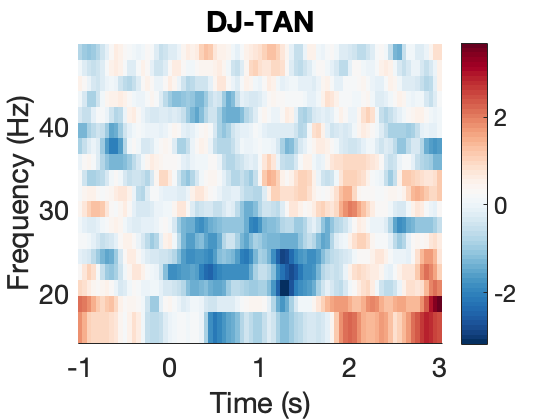

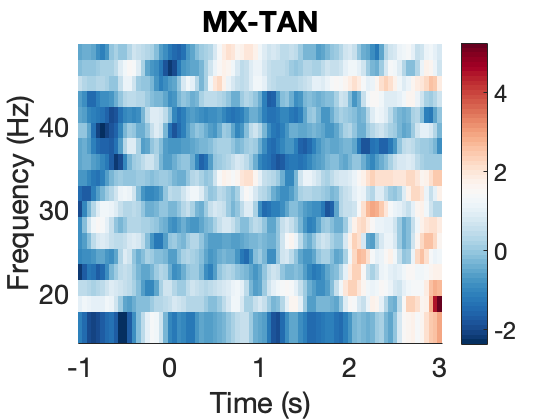

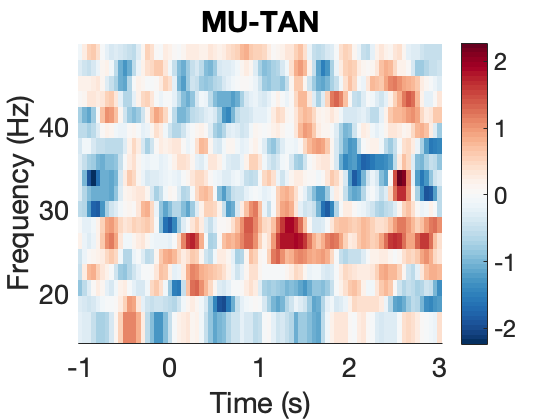

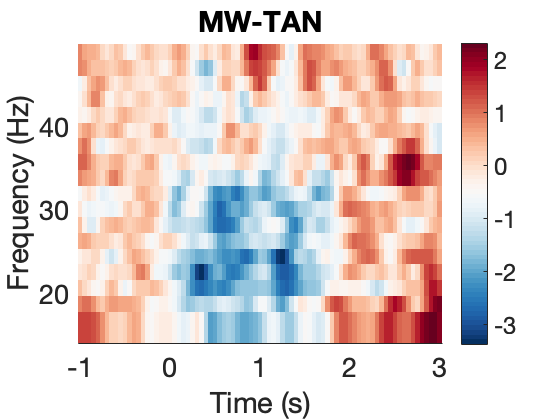

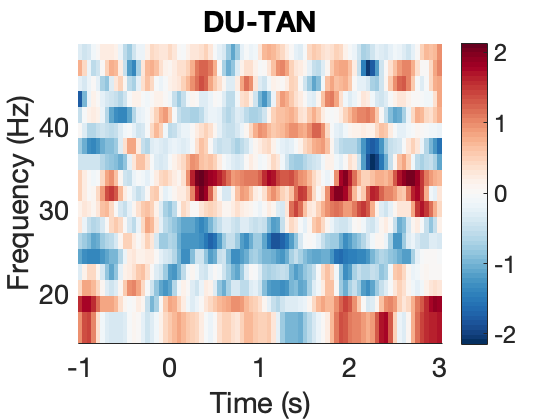

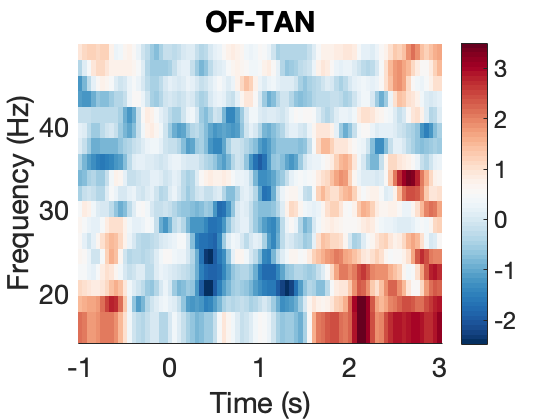

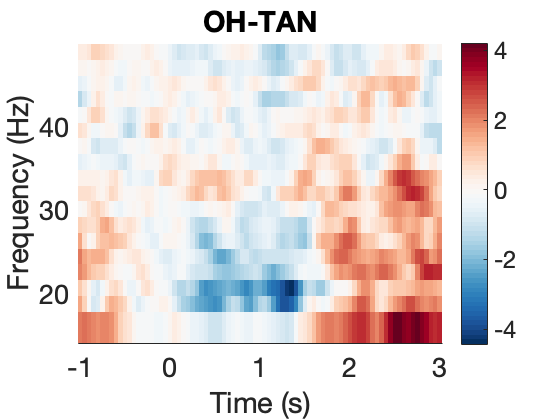

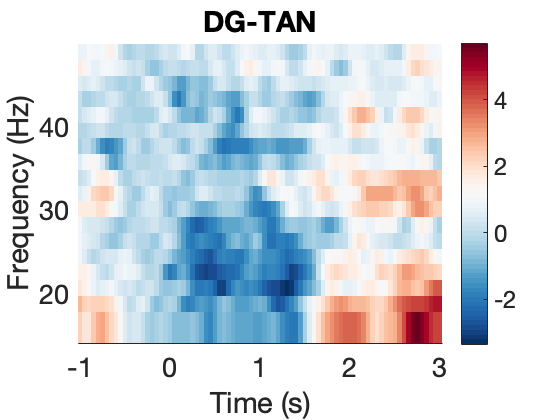

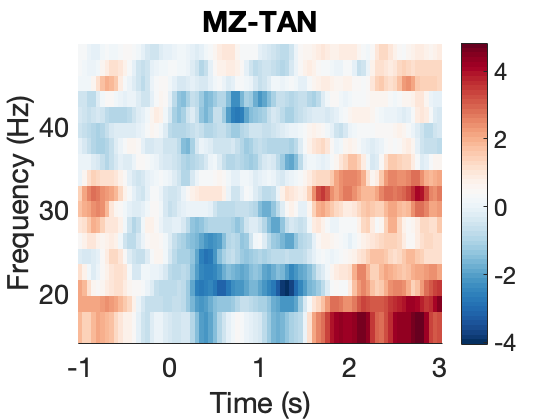

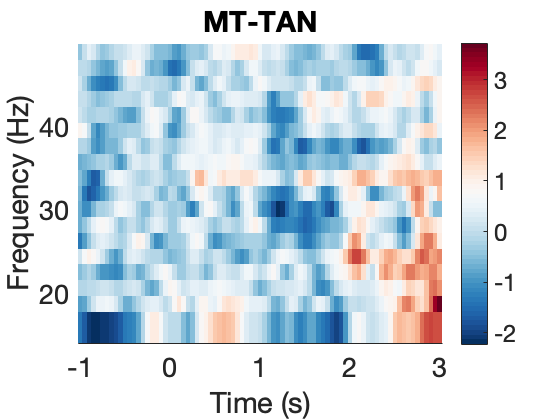

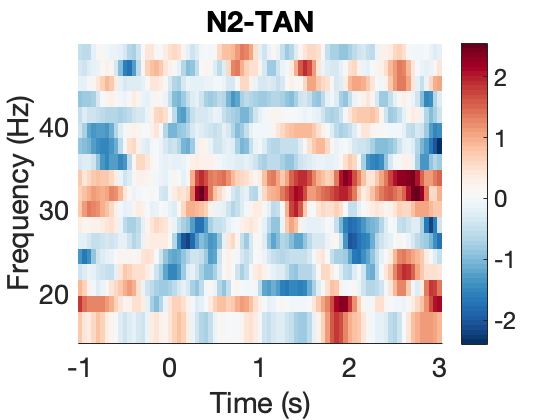

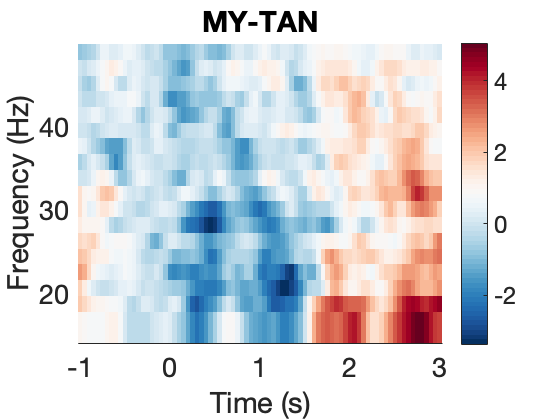

In [35]:
%% TFR
cfg              = [];
cfg.output       = 'pow';
cfg.channel      = 'all';
cfg.method       = 'mtmconvol';
cfg.taper        = 'hanning';
cfg.pad          = 'nextpow2';
cfg.foi          = 1:2:100;
cfg.t_ftimwin    = ones(length(cfg.foi),1).*0.5;   % length of time window = 0.5 sec
cfg.toi          = -1.5:0.05:3.5;
TFR              = ft_freqanalysis(cfg, data);

% Plot each sensor in turn
for i = 1:length(TFR.label)
    cfg = [];
    cfg.channel = TFR.label{i};
    cfg.parameter = 'powspctrm';
    cfg.baselinetype = 'db';
    cfg.title = TFR.label{i};
    cfg.baseline = [-0.5 0];
    cfg.xlim     = [-1 3];
    cfg.ylim     = [14 48];
    cfg.masknans = 'no';
    cfg.interactive  = 'no';
    figure; ft_singleplotTFR(cfg,TFR);
    try
    ft_hastoolbox('brewermap', 1);         % ensure this toolbox is on the path
    colormap(flipud(brewermap(64,'RdBu'))) % change the colormap
    catch
        ft_warning('Using default colormap')
    end
    xlabel('Time (s)'); ylabel('Frequency (Hz)');
    set(gca,'FontSize',20); drawnow;
    drawnow;
end

### Get location of point in left motor cortex for individual's MRI
- mmsMQ0484_orig.img is Gareth's MRI from which the scannercast was made

In [ ]:
%% Compute nonlinear warping between MNI brain and individual's MRI
mri             = ft_read_mri(fullfile(data_dir,'mmsMQ0484_orig.img'));
mri.coordsys    = 'neuromag';

cfg             = [];
cfg.template    = mri;
cfg.nonlinear   = 'yes';
norm            = ft_volumenormalise([],mri);

% Point in Left Motor Cortex
pos = [-38 -32 66];

% Now we warp the MNI coordinates using the nonlinear warping parameters
posback         = ft_warp_apply(norm.params,pos,'sn2individual');
% xyz positions in individual coordinates
pos_grid        = ft_warp_apply(pinv(norm.initial),posback);


### Source Analysis: Create Leadfield
- The headmodel and sourcemodel3d variables were computed as part of the scannercast pipeline for Gareth's hingecast
- Please adapt for your own data

Preparing Leadfield
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/ft_checkconfig.m' at line 128
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/ft_prepare_leadfield.m' at line 133

using gradiometers specified in the configuration
computing surface normals
creating sourcemodel based on user specified dipole positions
using gradiometers specified in the configuration
1 dipoles inside, 0 dipoles outside brain
the call to "ft_prepare_sourcemodel" took 4 seconds and required the additional allocation of an estimated 0 MB
computing leadfield
computing leadfield 1/1
the call to "ft_prepare_leadfield" took 4 seconds and required the additional allocation of an estimated 10 MB
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/plotting/ft_plot_vol.m' at line 11



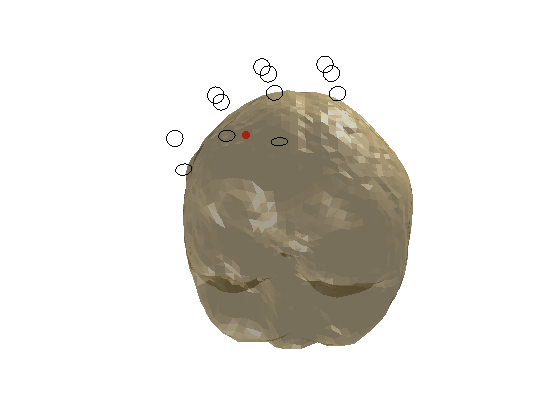

In [24]:
%% Load the headmodel and sourcemodel3d variables & compute leadfield
load(fullfile(data_dir,'headmodel.mat'));
load(fullfile(data_dir,'sourcemodel3d.mat'));

disp('Preparing Leadfield');
cfg                 = [];
cfg.method          ='lcmv';
cfg.channel         = data.label;
cfg.grid.pos        = pos_grid;
cfg.grid.unit       = 'mm';
cfg.headmodel       = headmodel;
cfg.grad            = rawData.grad;
cfg.normalize       = 'yes' ; %Normalise Leadfield: 'yes' for beamformer
lf_2                = ft_prepare_leadfield(cfg);

% make a figure of the single subject{i} headmodel, and grid positions
figure; hold on;
ft_plot_vol(headmodel,  'facecolor', 'cortex', 'edgecolor', 'none');
alpha 0.5; camlight;
ft_plot_mesh(lf_2.pos(lf_2.inside,:),'vertexsize',20,'vertexcolor','r');
ft_plot_sens(rawData.grad, 'style', 'r*'); view([0,0]);


### Band-pass filter the data in the beta-band (13-30Hz)

In [ ]:
%% BP Filter
cfg                = [];
cfg.bpfilter       = 'yes';
cfg.bpfreq         = [14 30];    %band-pass filter in the required range
data_filtered      = ft_preprocessing(cfg,data);

### Compute Covariance Matrix
- Using data between -2 and +1s 

In [ ]:
% Here we are keeping all parts of the trial to compute the
% covariance matrix --> common filter
cfg                     = [];
cfg.channel             = data.label;
cfg.covariance          = 'yes';
cfg.covariancewindow    = [-2 1];
avg                     = ft_timelockanalysis(cfg,data);

### Perform beamforming

In [ ]:
cfg                    = [];
cfg.channel            = data.label;
cfg.grad               = rawData.grad;
cfg.method             = 'lcmv';
cfg.grid               = lf_2;
cfg.headmodel          = headmodel;
cfg.lcmv.keepfilter    = 'yes';
cfg.lcmv.fixedori      = 'yes';
cfg.lcmv.projectnoise  = 'yes';
%cfg.lcmv.weightnorm   = 'nai';
cfg.lcmv.lambda        = '10%';
sourceall              = ft_sourceanalysis(cfg, avg);

% Find filter
filter = sourceall.avg.filter{1,1};

% Multiply data by spatial filter
VE = [];
VE.label = {'max'};
VE.trialinfo = data.trialinfo;
for subs=1:(length(data.trialinfo))
    % note that this is the non-filtered "raw" data
    VE.time{subs}       = data.time{subs};
    VE.trial{subs}(1,:) = filter(1,:)*data.trial{subs}(:,:);
end

### Perform TFR Analysis on this Virtual Electrode & Plot

the input is raw data with 1 channels and 60 trials
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/private/fixsampleinfo.m' at line 80
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/ft_datatype_raw.m' at line 147
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/ft_checkdata.m' at line 268
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/ft_freqanalysis.m' at line 212

 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/private/fixsampleinfo.m' at line 93
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/ft_datatype_raw.m' at line 147
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/utilities/ft_checkdata.m' at line 268
 In '/Users/rseymoue/Documents/GitHub/fieldtrip/ft_freqanalysis.m' at line 212

> In fixsampleinfo (line 94)
  In ft_datatype_raw (line 147)
  In ft_checkdata (line 268)
  In ft_freqanalysis (line 212)
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
processing trials
trial 6

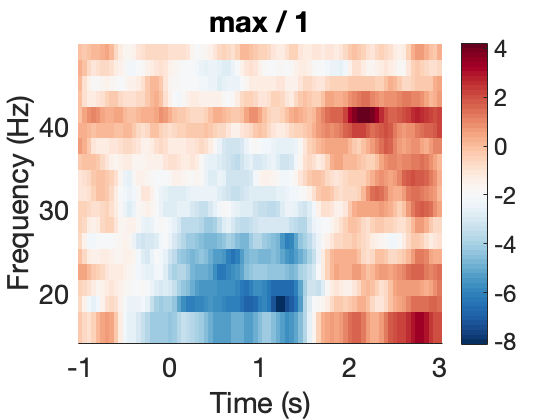

In [33]:
cfg              = [];
cfg.output       = 'pow';
cfg.channel      = 'all';
cfg.method       = 'mtmconvol';
cfg.taper        = 'hanning';
cfg.pad          = 'nextpow2';
cfg.foi          = 1:2:100;
cfg.t_ftimwin    = ones(length(cfg.foi),1).*0.5;   % length of time window = 0.5 sec
cfg.toi          = -1.5:0.05:3.5;
TFR              = ft_freqanalysis(cfg, VE);


cfg                 = [];
cfg.parameter       = 'powspctrm';
cfg.baselinetype    = 'db';
cfg.baseline        = [-2 -1];
cfg.xlim            = [-1 3];
cfg.ylim            = [14 48];
%cfg.zlim     = 'maxabs';
figure; ft_singleplotTFR(cfg,TFR);

try
ft_hastoolbox('brewermap', 1);         % ensure this toolbox is on the path
colormap(flipud(brewermap(64,'RdBu'))) % change the colormap
catch
    disp('Using default colormap');
end
xlabel('Time (s)'); ylabel('Frequency (Hz)');
set(gca,'FontSize',20); drawnow;
drawnow;
